In [30]:
# Load data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.naive_bayes import GaussianNB

%matplotlib inline

In [22]:
data_dir = './bikes_final/'
data = pd.read_csv(data_dir + 'per_station/519.csv')
print('Len', len(data))
print(data.columns)

Len 4789
Index(['Unnamed: 0', 'eightd_has_available_keys', 'is_installed', 'is_renting',
       'is_returning', 'last_reported', 'num_bikes_available',
       'num_bikes_disabled', 'num_docks_available', 'num_docks_disabled',
       'station_id', 'weather_ts', 'apparentTemperature', 'cloudCover',
       'dewPoint', 'humidity', 'icon', 'nearestStormBearing',
       'nearestStormDistance', 'ozone', 'precipIntensity',
       'precipIntensityError', 'precipProbability', 'precipType', 'pressure',
       'summary', 'temperature', 'time', 'visibility', 'windBearing',
       'windSpeed', 'traffic_0_asof', 'traffic_0_distance', 'traffic_0_linkId',
       'traffic_0_speed', 'traffic_0_travel_time', 'traffic_1_asof',
       'traffic_1_distance', 'traffic_1_linkId', 'traffic_1_speed',
       'traffic_1_travel_time', 'traffic_2_asof', 'traffic_2_distance',
       'traffic_2_linkId', 'traffic_2_speed', 'traffic_2_travel_time', 'y_10m',
       'y_15m', 'y_30m', 'y_45m', 'y_60m', 'y_90m', 'y_120m'],
 

In [8]:
def parse_datetime(df):
    # Turn date columns from string to datetime64
    date_columns = [
        'last_reported',
        'traffic_0_asof',
        'traffic_1_asof',
        'traffic_2_asof'
    ]
    for c in date_columns:
        df[c] = pd.to_datetime(df[c], infer_datetime_format=True)

def scale_bikes_and_docks(data, capacity):
    data['num_bikes_available_scaled'] = data['num_bikes_available'] / capacity
    data['num_bikes_disabled_scaled'] = data['num_bikes_disabled'] / capacity
    data['num_docks_available_scaled'] = data['num_docks_available'] / capacity
    data['num_docks_disabled_scaled'] = data['num_docks_disabled'] / capacity
    
def get_time_features(df):
    df['day_of_week'] = df['last_reported'].dt.dayofweek
    df['hour_of_day'] = df['last_reported'].dt.hour + df['last_reported'].dt.minute / 60
    df['is_weekend'] = (df['day_of_week'] >= 5) * 1.0

parse_datetime(data)
scale_bikes_and_docks(data, 61)
get_time_features(data)
#data_random_slice = data.iloc[np.random.permutation(len(shuffle))[:15]]
data_random_slice = data.iloc[:15]
data_random_slice[[
        'last_reported', 
        'num_bikes_available_scaled', 
        'day_of_week', 
        'hour_of_day',
        'is_weekend']]

,last_reported,num_bikes_available_scaled,day_of_week,hour_of_day,is_weekend
0,2016-10-17 13:41:47,0.098361,0,13.683333,0.0
1,2016-10-17 13:49:11,0.032787,0,13.816667,0.0
2,2016-10-17 13:54:57,0.098361,0,13.900000,0.0
3,2016-10-17 13:59:48,0.016393,0,13.983333,0.0
4,2016-10-17 14:00:22,0.000000,0,14.000000,0.0
5,2016-10-17 14:06:28,0.032787,0,14.100000,0.0
6,2016-10-17 14:14:01,0.049180,0,14.233333,0.0
7,2016-10-17 14:19:35,0.131148,0,14.316667,0.0
8,2016-10-17 14:22:17,0.131148,0,14.366667,0.0
9,2016-10-17 14:29:34,0.163934,0,14.483333,0.0


traffic_0_speed good records: 3007 - mean: 15.1068207516
traffic_1_speed good records: 3842 - mean: 16.9239042166
traffic_2_speed good records: 4313 - mean: 40.4171156967


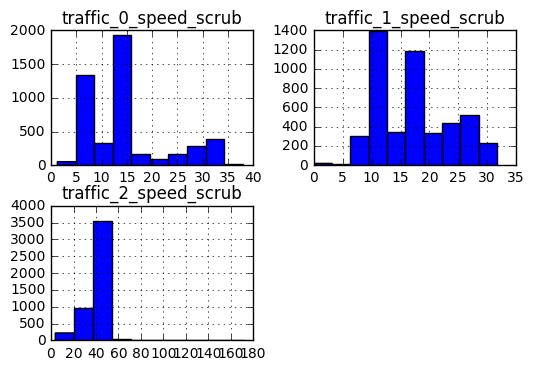

In [9]:
def set_outdated_traffic_info_to_mean(data):
    # Hide traffic information that is outdated
    limit_m = 5.0
    for i in [0, 1, 2]:
        speed_col = 'traffic_{}_speed'.format(i)
        datediff = data['last_reported'] - data['traffic_{}_asof'.format(i)]
        datediff_m = datediff / np.timedelta64(1, 'm')
        have_data = datediff_m < limit_m
        good_speeds = data[have_data][speed_col]
        mean = np.mean(good_speeds)
        print(speed_col, 'good records:', len(good_speeds), '- mean:', mean)

        speeds = data[speed_col].copy()
        speeds[~have_data] = mean
        data[speed_col + '_scrub'] = speeds

    data[['traffic_0_speed_scrub', 'traffic_1_speed_scrub', 'traffic_2_speed_scrub']].hist()
    data[['traffic_0_speed_scrub', 'traffic_1_speed_scrub', 'traffic_2_speed_scrub']].describe()
    
set_outdated_traffic_info_to_mean(data)

In [10]:
def drop_columns(data):
    return data.drop([
            'Unnamed: 0',
            'eightd_has_available_keys',
            'summary',
            'traffic_0_linkId',
            'traffic_1_linkId',
            'traffic_2_linkId',
            'traffic_0_asof', # no longer useful
            'traffic_1_asof',
            'traffic_2_asof',
            'traffic_0_speed', # unclean speeds
            'traffic_1_speed',
            'traffic_2_speed',
            'time',
            'icon',
            'weather_ts',
            'is_installed',
            'is_renting',
            'is_returning',
            'nearestStormBearing',
            'precipIntensityError',
            'precipType',
            'num_bikes_available',
            'num_docks_available',
            'num_bikes_disabled',
            'num_docks_disabled',
            'num_docks_disabled_scaled',
            
            'last_reported',
            'station_id',
            
            'traffic_0_distance',
            'traffic_1_distance',
            'traffic_2_distance',
            'traffic_0_travel_time',
            'traffic_1_travel_time',
            'traffic_2_travel_time',
            'y_10m',
            'y_15m',
            'y_30m',
            'y_45m',
            #'y_60m',
            'y_90m',
            'y_120m',
        ], axis=1)
data_drop = drop_columns(data)
print(data_drop.as_matrix().shape)
print(data_drop.columns)
data_drop[:3]

(4789, 23)
Index(['apparentTemperature', 'cloudCover', 'dewPoint', 'humidity',
       'nearestStormDistance', 'ozone', 'precipIntensity', 'precipProbability',
       'pressure', 'temperature', 'visibility', 'windBearing', 'windSpeed',
       'y_60m', 'num_bikes_available_scaled', 'num_bikes_disabled_scaled',
       'num_docks_available_scaled', 'day_of_week', 'hour_of_day',
       'is_weekend', 'traffic_0_speed_scrub', 'traffic_1_speed_scrub',
       'traffic_2_speed_scrub'],
      dtype='object')


,apparentTemperature,cloudCover,dewPoint,humidity,nearestStormDistance,ozone,precipIntensity,precipProbability,pressure,temperature,...,y_60m,num_bikes_available_scaled,num_bikes_disabled_scaled,num_docks_available_scaled,day_of_week,hour_of_day,is_weekend,traffic_0_speed_scrub,traffic_1_speed_scrub,traffic_2_speed_scrub
0,77.33,0.51,62.13,0.60,16,280.78,0.0,0.0,1013.38,77.33,...,0.196429,0.098361,0.081967,0.819672,0,13.683333,0.0,24.230000,16.160000,45.98
1,78.04,0.25,62.26,0.58,39,280.50,0.0,0.0,1013.28,78.04,...,0.250000,0.032787,0.081967,0.885246,0,13.816667,0.0,27.960000,16.780000,39.77
2,78.04,0.25,62.26,0.58,39,280.50,0.0,0.0,1013.28,78.04,...,0.214286,0.098361,0.081967,0.819672,0,13.900000,0.0,15.106821,16.923904,44.74


In [127]:
def bucket_y_variable(data_drop, threshold_empty=.05, threshold_full=.95):
    y_60m = data_drop['y_60m'].copy()
    y_60m[y_60m < 0] = None

    data_valid = data_drop[data_drop['y_60m'] >= 0].copy()
    yvar = np.zeros(len(data_valid))
    yvar[(data_valid['y_60m'] < threshold_empty).as_matrix()] = -1
    yvar[(data_valid['y_60m'] > threshold_full).as_matrix()] = 1
    data_valid['y'] = yvar

    return data_valid.drop(['y_60m'], axis=1)

data_cleaned_05p = bucket_y_variable(data_drop, threshold_empty=0.05, threshold_full=0.95)
data_cleaned_10p = bucket_y_variable(data_drop, threshold_empty=0.10, threshold_full=0.90)
print('Cleaned data size:', len(data_cleaned_05p))
data_cleaned_05p.describe().T

Cleaned data size: 3832


,count,mean,std,min,25%,50%,75%,max
apparentTemperature,3832.0,56.968411,10.669506,31.560000,50.210000,56.280000,65.590000,84.620000
cloudCover,3832.0,0.342756,0.304348,0.000000,0.080000,0.260000,0.560000,1.000000
dewPoint,3832.0,44.664653,11.671458,24.970000,34.805000,42.195000,55.090000,68.490000
humidity,3832.0,0.629105,0.140517,0.350000,0.520000,0.610000,0.720000,0.950000
nearestStormDistance,3832.0,73.985647,130.291373,0.000000,7.000000,19.000000,66.500000,829.000000
ozone,3832.0,279.242067,13.675113,246.790000,270.525000,276.630000,287.205000,315.310000
precipIntensity,3832.0,0.001480,0.012651,0.000000,0.000000,0.000000,0.000000,0.403900
precipProbability,3832.0,0.047508,0.201815,0.000000,0.000000,0.000000,0.000000,1.000000
pressure,3832.0,1016.246975,30.282454,419.850000,1012.670000,1019.230000,1023.190000,1031.170000
temperature,3832.0,57.748022,9.631278,38.070000,50.210000,56.280000,65.590000,83.620000


In [136]:
def make_xy(dataset):
    X = dataset.drop('y', axis=1)
    Y = dataset['y']
    return X, Y


In [137]:
def do_gnb(train_X, train_Y, test_X, test_Y):
    
    gnb = GaussianNB()
    gnb.fit(train_X, train_Y)
    test_pred = gnb.predict(test_X)
    
    acc = accuracy_score(test_Y, test_pred)
    print('Accuracy:', acc)
    
    print(confusion_matrix(test_Y, test_pred))

    plt.figure()
    plt.plot(test_Y.as_matrix()[100:500], 'b')
    plt.plot(test_pred[100:500], 'g')
    plt.plot(0.5 * (test_Y.as_matrix() - test_pred)[100:500], 'r')
    plt.ylim(-3, 3)
    plt.show()
    
    return gnb, test_pred

In [138]:
training = data_cleaned_05p[:2000]
test = data_cleaned_05p[2000:]
training_X, training_y = make_xy(training)
test_X, test_y = make_xy(test)

training_X.head()

,apparentTemperature,cloudCover,dewPoint,humidity,nearestStormDistance,ozone,precipIntensity,precipProbability,pressure,temperature,...,windSpeed,num_bikes_available_scaled,num_bikes_disabled_scaled,num_docks_available_scaled,day_of_week,hour_of_day,is_weekend,traffic_0_speed_scrub,traffic_1_speed_scrub,traffic_2_speed_scrub
0,77.33,0.51,62.13,0.60,16,280.78,0.0,0.0,1013.38,77.33,...,3.43,0.098361,0.081967,0.819672,0,13.683333,0.0,24.230000,16.160000,45.98
1,78.04,0.25,62.26,0.58,39,280.50,0.0,0.0,1013.28,78.04,...,4.81,0.032787,0.081967,0.885246,0,13.816667,0.0,27.960000,16.780000,39.77
2,78.04,0.25,62.26,0.58,39,280.50,0.0,0.0,1013.28,78.04,...,4.81,0.098361,0.081967,0.819672,0,13.900000,0.0,15.106821,16.923904,44.74
3,78.04,0.25,62.26,0.58,39,280.50,0.0,0.0,1013.28,78.04,...,4.81,0.016393,0.081967,0.901639,0,13.983333,0.0,26.720000,13.050000,44.74
4,77.53,0.18,61.30,0.57,35,280.23,0.0,0.0,1013.17,77.53,...,5.06,0.000000,0.081967,0.918033,0,14.000000,0.0,15.106821,16.923904,44.74


Accuracy: 0.510371179039
[[467  42  14]
 [550 427 283]
 [  0   8  41]]


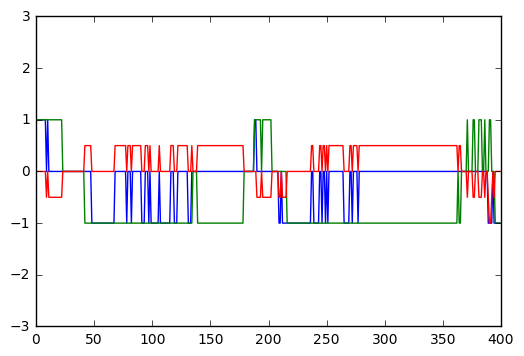

In [139]:
gnb, gnb_pred = do_gnb(training_X, training_y, test_X, test_y)

Accuracy: 0.551310043668
[[418  60  10]
 [455 528 279]
 [  5  13  64]]


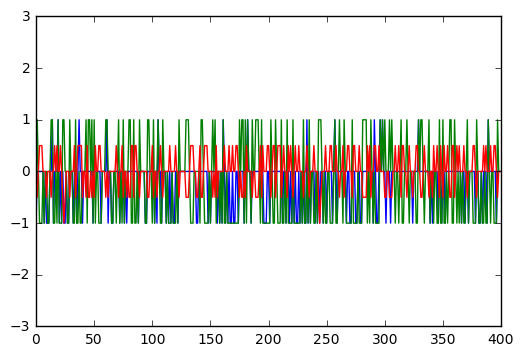

In [140]:
data_cleaned_shuf = data_cleaned_05p.copy()
data_cleaned_shuf = data_cleaned_shuf.iloc[np.random.permutation(len(data_cleaned_shuf))]
data_cleaned_shuf.reset_index(drop=True)

training = data_cleaned_shuf[:2000]
test = data_cleaned_shuf[2000:]
training_X, training_y = make_xy(training)
test_X, test_y = make_xy(test)
gnb, gnb_pred = do_gnb(training_X, training_y, test_X, test_y)

Accuracy: 0.590611353712
[[669  70  10]
 [399 336 255]
 [  2  14  77]]


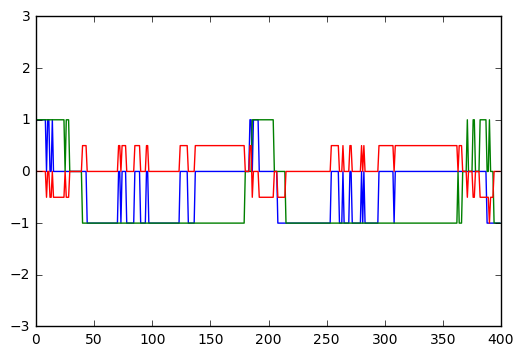

In [141]:
training = data_cleaned_10p[:2000]
test = data_cleaned_10p[2000:]
training_X, training_y = make_xy(training)
test_X, test_y = make_xy(test)
gnb, gnb_pred = do_gnb(training_X, training_y, test_X, test_y)

Accuracy: 0.625
[[595  57  14]
 [359 414 231]
 [  7  19 136]]


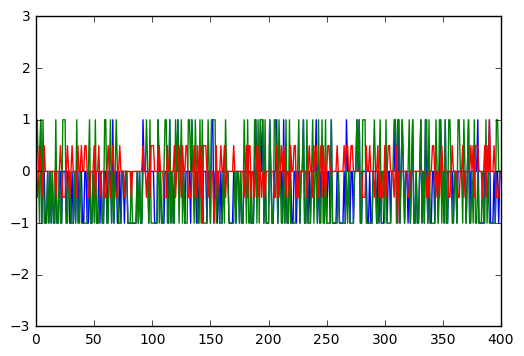

In [142]:
data_cleaned_shuf = data_cleaned_10p.copy()
data_cleaned_shuf = data_cleaned_shuf.iloc[np.random.permutation(len(data_cleaned_shuf))]
data_cleaned_shuf.reset_index(drop=True)

training = data_cleaned_shuf[:2000]
test = data_cleaned_shuf[2000:]
training_X, training_y = make_xy(training)
test_X, test_y = make_xy(test)
gnb, gnb_pred = do_gnb(training_X, training_y, test_X, test_y)

In [76]:
from sklearn.metrics import roc_curve, auc
def plotROC(preds, truth, label_string):
    # call the roc_curve function to get the ROC X and Y values
    fpr, tpr, thresholds = roc_curve(truth, preds)
    # Input fpr and tpr into the auc function to get the AUC
    roc_auc = auc(fpr, tpr)
    
    #chooses a random color for plotting
    c = (np.random.rand(), np.random.rand(), np.random.rand())

    #create a plot and set some options
    plt.plot(fpr, tpr, color = c, label = label_string + ' (AUC = %0.3f)' % roc_auc)
    
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('ROC')
    plt.legend(loc="lower right")
    
    return roc_auc


In [83]:
# needs binary data, should revisit
# if data is not binary, pos_label needs to be specified for roc_curve()
# plotROC(gnb_pred, dev_y, 'NB')

In [147]:
gnb.class_prior_()

#most predictive features
#features = list(training_X.columns)
#feature_imp = gnb.feature_importances_

#top_features = pd.Series(data=feature_imp,index=features)
#top_features.sort_values(inplace=True, ascending=False)

#plot
#index = np.arange(0,10,1)
#plt.figure(figsize=(20,5))
#plt.bar(index,top_features[0:10], width = .8, align='center')
#plt.xticks(index, features[0:10])
#plt.axis('tight')

TypeError: 'numpy.ndarray' object is not callable